In [3]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ===================== #
# 1. Pregătim datele
# ===================== #

dataset_dir = 'dataset'
data = []

# Adăugăm cifrele la etichete
all_labels = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z')+1)] + [chr(i) for i in range(ord('A'), ord('Z')+1)]

# Mapăm literele și cifrele la indici
label_to_idx = {label: i for i, label in enumerate(all_labels)}
idx_to_label = {i: label for label, i in label_to_idx.items()}

# Citim datele
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.png'):
            label_folder = os.path.basename(root)
            if '_' in label_folder:
                label = label_folder.split('_')[0]  # obținem litera sau cifra
                img_path = os.path.join(root, file)
                data.append((img_path, label))

# Split între datele de training și testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Număr imagini de antrenare: {len(train_data)}")
print(f"Număr imagini de testare: {len(test_data)}")


Număr imagini de antrenare: 140397
Număr imagini de testare: 35100


In [ ]:
# ===================== #
# 2. Dataset + transformări
# ===================== #

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class OCRDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = label_to_idx[label]
        return image, label_idx

train_dataset = OCRDataset(train_data, transform=transform)
test_dataset = OCRDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ===================== #
# 3. Model CNN simplu
# ===================== #

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda")
model = SimpleCNN(num_classes=len(all_labels)).to(device)



In [ ]:
# ===================== #
# 4. Antrenare
# ===================== #

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 10

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / total)
    train_accuracies.append(correct / total)

    # Eval
    model.eval()
    with torch.no_grad():
        total_loss, correct, total = 0, 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        test_losses.append(total_loss / total)
        test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracies[-1]:.4f} - Loss: {train_losses[-1]:.4f} - Test Acc: {test_accuracies[-1]:.4f} - Loss: {test_losses[-1]:.4f}")


Epoch 1/10 - Train Acc: 0.9171 - Loss: 0.2785 - Test Acc: 0.9089 - Loss: 0.3102
Epoch 2/10 - Train Acc: 0.9264 - Loss: 0.2377 - Test Acc: 0.9134 - Loss: 0.2944
Epoch 3/10 - Train Acc: 0.9351 - Loss: 0.2084 - Test Acc: 0.9142 - Loss: 0.2983
Epoch 4/10 - Train Acc: 0.9401 - Loss: 0.1887 - Test Acc: 0.9177 - Loss: 0.3002
Epoch 5/10 - Train Acc: 0.9451 - Loss: 0.1733 - Test Acc: 0.9153 - Loss: 0.3329
Epoch 6/10 - Train Acc: 0.9481 - Loss: 0.1649 - Test Acc: 0.9172 - Loss: 0.3328
Epoch 7/10 - Train Acc: 0.9501 - Loss: 0.1559 - Test Acc: 0.9207 - Loss: 0.3405
Epoch 8/10 - Train Acc: 0.9533 - Loss: 0.1471 - Test Acc: 0.9166 - Loss: 0.3759
Epoch 9/10 - Train Acc: 0.9547 - Loss: 0.1435 - Test Acc: 0.9192 - Loss: 0.3841
Epoch 10/10 - Train Acc: 0.9562 - Loss: 0.1399 - Test Acc: 0.9194 - Loss: 0.3696


In [21]:
# ===================== #
# 2. Dataset + Transformări cu Augmentare
# ===================== #

# Transformări pentru setul de antrenament (cu augmentare)
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(5),  # mică variație
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Transformări pentru setul de testare (fără augmentare)
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class OCRDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = label_to_idx[label]
        return image, label_idx

# Aplică transformările corecte la seturile de date
train_dataset = OCRDataset(train_data, transform=transform_train)
test_dataset = OCRDataset(test_data, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ===================== #
# 3. Model CNN simplu (cu BatchNorm și Dropout)
# ===================== #

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [22]:
# ===================== #
# 4. Antrenare (cu Early Stopping)
# ===================== #

device = torch.device("cuda")

model = SimpleCNN(num_classes=len(all_labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

num_epochs = 20
best_test_loss = float('inf')
patience = 3
epochs_no_improve = 0

print("\nStarting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train

    # Evaluation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = correct_test / total_test
    scheduler.step(test_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Acc: {train_acc:.4f} - Loss: {train_loss:.4f} - "
          f"Test Acc: {test_acc:.4f} - Loss: {test_loss:.4f}")

    # Early stopping check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
        # You might want to save the model here, as this is the best one found so far
        # torch.save(model.state_dict(), 'best_ocr_model.pth')
    else:
        epochs_no_improve += 1
        print(f"Test loss did not improve. Patience: {epochs_no_improve}/{patience}")

    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch + 1} as test loss did not improve for {patience} consecutive epochs.")
        break

print("Training finished.")


Starting training...
Epoch 1/20 - Train Acc: 0.1951 - Loss: 2.8462 - Test Acc: 0.7797 - Loss: 1.0805
Epoch 2/20 - Train Acc: 0.4979 - Loss: 1.6787 - Test Acc: 0.8533 - Loss: 0.5768
Epoch 3/20 - Train Acc: 0.6893 - Loss: 1.0751 - Test Acc: 0.8716 - Loss: 0.4716
Epoch 4/20 - Train Acc: 0.7571 - Loss: 0.8596 - Test Acc: 0.8779 - Loss: 0.4371
Epoch 5/20 - Train Acc: 0.7897 - Loss: 0.7478 - Test Acc: 0.8883 - Loss: 0.3964
Epoch 6/20 - Train Acc: 0.8079 - Loss: 0.6784 - Test Acc: 0.8914 - Loss: 0.3812
Epoch 7/20 - Train Acc: 0.8201 - Loss: 0.6363 - Test Acc: 0.8963 - Loss: 0.3653
Epoch 8/20 - Train Acc: 0.8282 - Loss: 0.6060 - Test Acc: 0.8986 - Loss: 0.3541
Epoch 9/20 - Train Acc: 0.8331 - Loss: 0.5844 - Test Acc: 0.9002 - Loss: 0.3419
Epoch 10/20 - Train Acc: 0.8371 - Loss: 0.5715 - Test Acc: 0.9037 - Loss: 0.3366
Epoch 11/20 - Train Acc: 0.8393 - Loss: 0.5622 - Test Acc: 0.9023 - Loss: 0.3366
Test loss did not improve. Patience: 1/3
Epoch 12/20 - Train Acc: 0.8424 - Loss: 0.5520 - Test A

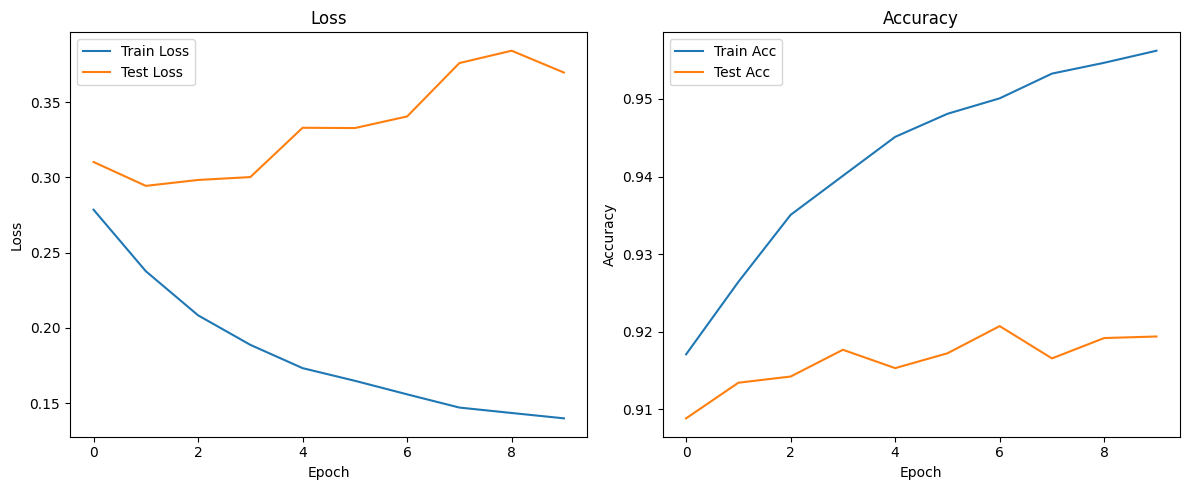

In [10]:
# ===================== #
# 5. Plot rezultate
# ===================== #

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import cv2
import numpy as np
import torch
from PIL import Image

def extract_lyrics_all_staffs(image_path, model, device, transform, idx_to_label, offset_below_staff=20, lyrics_height=40):
    # Încarcă imaginea
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detectăm linii orizontale (portativele)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    # Colectăm doar liniile orizontale
    horizontal_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y1 - y2) < 2:  # aproape orizontale
            horizontal_lines.append((y1 + y2) // 2)

    # Grupăm liniile în portative (câte 5 linii apropiate)
    horizontal_lines = sorted(horizontal_lines)
    staff_lines = []
    current = []

    for y in horizontal_lines:
        if not current or abs(y - current[-1]) < 10:
            current.append(y)
        else:
            if len(current) >= 4:
                staff_lines.append(current)
            current = [y]
    if len(current) >= 4:
        staff_lines.append(current)

    # Extragem zona de versuri de sub fiecare portativ
    model.eval()
    full_text = ""
    with torch.no_grad():
        for staff in staff_lines:
            y_bottom = max(staff)
            y_start = y_bottom + offset_below_staff
            y_end = y_start + lyrics_height

            lyrics_region = img[y_start:y_end, :]

            gray_crop = cv2.cvtColor(lyrics_region, cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(gray_crop, 127, 255, cv2.THRESH_BINARY_INV)
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            boxes = [cv2.boundingRect(c) for c in contours if cv2.boundingRect(c)[2] > 5 and cv2.boundingRect(c)[3] > 5]
            boxes = sorted(boxes, key=lambda b: b[0])  # sort left to right

            line_text = ""
            for (x, y, w, h) in boxes:
                char_crop = lyrics_region[y:y+h, x:x+w]
                size = max(w, h)
                canvas = np.ones((size, size, 3), dtype=np.uint8) * 255
                x_off = (size - w) // 2
                y_off = (size - h) // 2
                canvas[y_off:y_off + h, x_off:x_off + w] = char_crop

                pil_img = Image.fromarray(canvas)
                tensor = transform(pil_img).unsqueeze(0).to(device)

                output = model(tensor)
                pred = torch.argmax(output, dim=1).item()
                line_text += idx_to_label[pred]
            full_text += line_text.strip() + "\n"

    return full_text.strip()



image_path = "image_.png"

# Rulează OCR
text_detectat = extract_lyrics_all_staffs(image_path, model, device, transform, idx_to_label, offset_below_staff=20, lyrics_height=40)


# Afișează rezultatul
print(f"Text recunoscut:\n{text_detectat}")

NameError: name 'model' is not defined